OpenGAN: Open-Set Recognition via Open Data Generation
================
**Supplemental Material for ICCV2021 Submission**


In this notebook, we demonstrate how we train the GAN-fea model on the TinyImageNet train-set, providing the closed-set images.

import packages
------------------

Some packages are installed automatically through Anaconda. PyTorch should be also installed.

In [2]:
from __future__ import print_function, division
import os, random, time, copy
from skimage import io, transform
import numpy as np
import libmr
import pandas as pd
import os.path as path
import scipy.io as sio
from scipy import misc
from scipy import ndimage, signal
import scipy
import pickle
import sys
import math
import matplotlib.pyplot as plt
import PIL.Image
from io import BytesIO
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
# from skimage.measure import compare_ssim as ssim
# from skimage.measure import compare_psnr as psnr

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import torchvision.utils as vutils

from utils.eval_funcs import *
from utils.dataset_tinyimagenet import *

import warnings # ignore warnings
warnings.filterwarnings("ignore")
print(sys.version)
print(torch.__version__)


manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

3.11.8 | packaged by conda-forge | (main, Feb 16 2024, 20:49:36) [Clang 16.0.6 ]
2.3.0
Random Seed:  999


Setup config parameters
 -----------------
 
 There are several things to setup, like which GPU to use, where to read images and save files, etc. Please read and understand this. By default, you should be able to run this script smoothly by changing nothing.

In [3]:
# set the random seed
torch.manual_seed(0)

################## set attributes for this project/experiment ##################
# config result folder
exp_dir = './exp' # experiment directory, used for reading the init model

modelFlag = 'Res18_fmnist'

project_name = 'step002_GANfea_v1_' + modelFlag   # we save all the checkpoints in this directory

# set device, which gpu to use.
device ='cpu'
if torch.cuda.is_available(): 
    device='cuda:1'


total_epoch_num = 100 # total number of epoch in training
batch_size = 128    

# newsize = (64, 64)
newsize = (28,28)

path_to_feats = './feats' # the path to cached off-the-shelf features
pklName = path.join(path_to_feats, modelFlag.lower()+'.pkl')



# For GAN-fea, we set the hyper-parameters as below.

# Number of channels in the training images. For color images this is 3
# nc = 512
nc = 1
# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1



# FMNIST dataset has 10 classes
nClassTotal = 10
nClassCloseset = nClassTotal

#project_name += '_K{}run{}'.format(nClassCloseset, runIdx)
if not os.path.exists(exp_dir): os.makedirs(exp_dir)

lr = 0.0001 # learning rate

num_epochs = total_epoch_num
# torch.mps.device_count()
# torch.mps.empty_cache()

save_dir = os.path.join(exp_dir, project_name)
print(save_dir)    
if not os.path.exists(save_dir): os.makedirs(save_dir)

log_filename = os.path.join(save_dir, 'train.log')

./exp/step002_GANfea_v1_Res18_fmnist


Define model architecture
---------

Here is the definition of the model architectures for generator and discriminator. Both are multi-layer perceptron (MLP) networks.

In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)     
        

class Generator(nn.Module):
    def __init__(self, ngpu=1, nz=100, ngf=64, nc=1):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.nz = nz
        self.ngf = ngf
        self.nc = nc
        
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            # Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
            nn.Conv2d( self.nz, self.ngf * 8, 1, 1, 0, bias=False),
            nn.BatchNorm2d(self.ngf * 8),
            nn.ReLU(True),
            # state size. (self.ngf*8) x 4 x 4
            nn.Conv2d(self.ngf * 8, self.ngf * 4, 1, 1, 0, bias=False),
            nn.BatchNorm2d(self.ngf * 4),
            nn.ReLU(True),
            # state size. (self.ngf*4) x 8 x 8
            nn.Conv2d( self.ngf * 4, self.ngf * 2, 1, 1, 0, bias=False),
            nn.BatchNorm2d(self.ngf * 2),
            nn.ReLU(True),
            # state size. (self.ngf*2) x 16 x 16
            nn.Conv2d( self.ngf * 2, self.ngf*4, 1, 1, 0, bias=False),
            nn.BatchNorm2d(self.ngf*4),
            nn.ReLU(True),
            # state size. (self.ngf) x 32 x 32
            nn.Conv2d( self.ngf*4, self.nc, 1, 1, 0, bias=True),
            #nn.Tanh()
            # state size. (self.nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

    
class Discriminator(nn.Module):
    def __init__(self, ngpu=1, nc=1, ndf=64):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.nc = nc
        self.ndf = ndf
        self.main = nn.Sequential(
            nn.Conv2d(self.nc, self.ndf*8, 1, 1, 0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf*8, self.ndf*4, 1, 1, 0, bias=False),
            nn.BatchNorm2d(self.ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf*4, self.ndf*2, 1, 1, 0, bias=False),
            nn.BatchNorm2d(self.ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf*2, self.ndf, 1, 1, 0, bias=False),
            nn.BatchNorm2d(self.ndf),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf, 1, 1, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

## initialize the networks

In [5]:
netG = Generator(ngpu=ngpu, nz=nz, ngf=ngf, nc=nc).to(device)
netD = Discriminator(ngpu=ngpu, nc=nc, ndf=ndf).to(device)

# Handle multi-gpu if desired
if ('cuda' in device) and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

    # Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)


if ('cuda' in device) and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
netG.apply(weights_init)

print(device)

cpu


## Sanity Check

In [6]:
noise = torch.randn(batch_size, nz, 1, 1, device=device)
# Generate fake image batch with G
fake = netG(noise)
predLabel = netD(fake)

print(noise.shape, fake.shape, predLabel.shape)

torch.Size([128, 100, 1, 1]) torch.Size([128, 512, 1, 1]) torch.Size([128, 1, 1, 1])


## setup dataset of TinyImageNet

In [8]:
with open(pklName, "rb") as fn:
    wholeData = pickle.load(fn)
print(wholeData.keys())

# Convert numpy array to torch tensor
WholeFeatVec = torch.from_numpy(wholeData['WholeFeatVec']).float()
# del wholeData

WholeFeatVec.unsqueeze_(-1).unsqueeze_(-1)
print(WholeFeatVec.shape)

dict_keys(['WholeFeatVec', 'labels'])
torch.Size([60000, 512, 1, 1])


## a helper function to read cached off-the-shelf features per closed images

In [9]:
class FeatDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.current_set_len = data.shape[0]        
        
    def __len__(self):        
        return self.current_set_len
    
    def __getitem__(self, idx):
        curdata = self.data[idx]        
        return curdata

In [10]:
trainset_closeset = FeatDataset(data=WholeFeatVec)
dataloader = DataLoader(trainset_closeset, batch_size=batch_size, shuffle=True, num_workers=0)

In [11]:
data_sampler = iter(dataloader)
feaList = next(data_sampler)
print(feaList.shape)

torch.Size([128, 512, 1, 1])


setup training
-----------

In [12]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr/1.5, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [14]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device).float()
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()
        

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 200 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
        
        
    cur_model_wts = copy.deepcopy(netG.state_dict())
    path_to_save_paramOnly = os.path.join(save_dir, 'epoch-{}.GNet'.format(epoch+1))
    torch.save(cur_model_wts, path_to_save_paramOnly)
    
    cur_model_wts = copy.deepcopy(netD.state_dict())
    path_to_save_paramOnly = os.path.join(save_dir, 'epoch-{}.DNet'.format(epoch+1))
    torch.save(cur_model_wts, path_to_save_paramOnly)

Starting Training Loop...
[0/100][0/469]	Loss_D: 1.3805	Loss_G: 0.6935	D(x): 0.5047	D(G(z)): 0.5013 / 0.5001


KeyboardInterrupt: 

## drawing the error curves

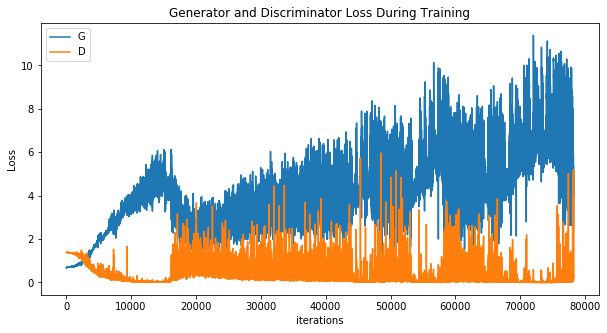

In [12]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig('learningCurves_{}.png'.format(modelFlag), bbox_inches='tight',transparent=True)
# plt.show()